<a href="https://colab.research.google.com/github/eku2005/FoodCaloriesPredict_finetune/blob/main/NutriVision_Colab_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🍔 NutriVision
Train a ResNet50 model on Food-101 and estimate calories.

## 🔧 Step 1: Install Required Libraries

In [5]:
!pip install tensorflow keras opencv-python pandas matplotlib scikit-learn


## 📁 Step 2: Upload Your Dataset & CSV

In [17]:
from google.colab import files

print(" Upload your Food-101 'images' folder zipped (e.g. food-101-images.zip)")
uploaded = files.upload()

# Unzip
import zipfile
import os

for fn in uploaded.keys():
    if fn.endswith('.zip'):
        with zipfile.ZipFile(fn, 'r') as zip_ref:
            zip_ref.extractall('subset')

print("Dataset extracted.")


 Upload your Food-101 'images' folder zipped (e.g. food-101-images.zip)


Saving subset.zip to subset (1).zip
Dataset extracted.


In [18]:
!ls

 calorie_lookup.csv   sample_data  'subset (1).zip'
 food-101	      subset	    subset.zip


In [30]:
!ls subset/subset/

apple_pie   chicken_curry  french_fries  pad_thai
cheesecake  dumplings	   lasagna


### 📥 Upload `calorie_lookup.csv`

In [7]:
uploaded = files.upload()


Saving calorie_lookup.csv to calorie_lookup.csv


## 📚 Step 3: Import Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input


## 🧠 Step 4: Prepare Data Generators

In [31]:
dataset_path = 'subset/subset/'

datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 5600 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.


## 🔧 Step 5: Build and Train ResNet50

In [39]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, validation_data=val_generator, epochs=10)


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - accuracy: 0.7327 - loss: 0.8231 - val_accuracy: 0.8636 - val_loss: 0.4004
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.9123 - loss: 0.2677 - val_accuracy: 0.8736 - val_loss: 0.3733
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 25s 144ms/step - accuracy: 0.9303 - loss: 0.2075 - val_accuracy: 0.8714 - val_loss: 0.3923
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.9514 - loss: 0.1432 - val_accuracy: 0.8671 - val_loss: 0.4148
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.9741 - loss: 0.0793 - val_accuracy: 0.8771 - val_loss: 0.4017
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.9877 - loss: 0.0508 - val_accuracy: 0.8750 - val_loss: 0.4096
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.9942 - loss: 0.0338 - val_accuracy: 0.8814 - val_loss: 0.4323
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 41s 143ms/step - accuracy: 0.9926 - loss: 0

## 📈 Step 6: Plot Accuracy

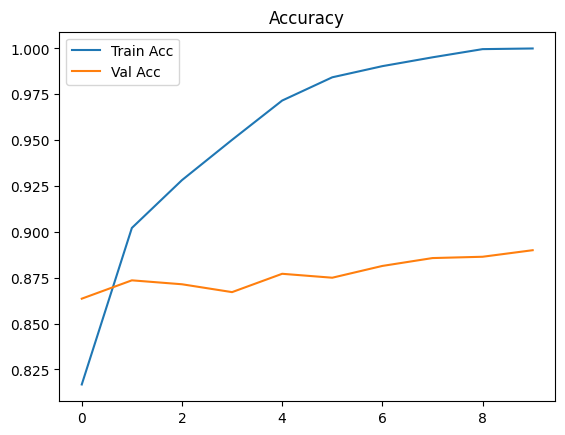

In [40]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()


## 💾 Step 7: Save Model

In [41]:
model.save("resnet50_finetuned.h5")
files.download("resnet50_finetuned.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 🥗 Step 8: Predict & Estimate Calories

Saving dumpling-de-res-barbacoa.jpg to dumpling-de-res-barbacoa (1).jpg


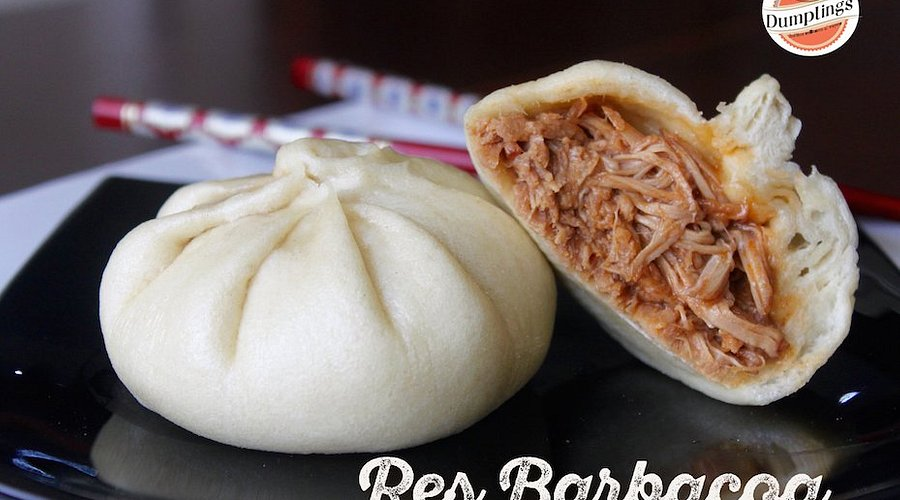

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
🍽 Predicted Food: dumplings
🔥 Estimated Calories: 238 kcal per 100g
🔍 Model Confidence: 96.12999725341797%


In [59]:
# --- Upload + Predict Cell (Colab Ready) ---
from google.colab import files
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load calorie data
calories = pd.read_csv("calorie_lookup.csv")

# Map index to label from training
index_to_label = {v: k for k, v in train_generator.class_indices.items()}

# Prediction + Calorie Estimation Function
def predict_and_estimate(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"❌ Could not read image: {image_path}")
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img)

    pred = model.predict(np.expand_dims(img, axis=0))
    label_idx = np.argmax(pred)
    predicted_label = index_to_label[label_idx]
    label_clean = predicted_label.replace('_', ' ')

    # Match with calorie CSV
    row = calories[calories['food_label'].str.lower() == label_clean.lower()]
    if not row.empty:
        kcal = row['avg_calories_per_100g'].values[0]
    else:
        kcal = "Unknown"

    confidence = round(np.max(pred) * 100, 2)
    return predicted_label, kcal, confidence

# Upload image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Show image
img = cv2.imread(img_path)
if img is not None:
    cv2_imshow(img)
else:
    print("❌ Could not load image")

# Predict
label, kcal, conf = predict_and_estimate(img_path, model)
print(f"🍽 Predicted Food: {label}")
print(f"🔥 Estimated Calories: {kcal} kcal per 100g")
print(f"🔍 Model Confidence: {conf}%")

